In [20]:
import pandas as pd

In [44]:
df = pd.read_csv("../data/processed/NY_SLI_ATTOM_NEW.csv", low_memory=False)
#df.info()
df.head()

,Service Line Locality,Street Address,Zip Code,State,"Lead Gooseneck, Pigtail or Connector Currently Present",Current Public Side SL Material,Was Public SL Material Ever Previously Lead,Public SL Material Verification Method,Public SL Installation or Replacement Date,Public SL Size,...,lot_size2,prop_class,year_built,living_size,size_ind,beds,baths_total,levels,market_total_value,construction_condition
0,Elmira,437 CLINTON ST. (WEST),14901,NY,NaN,Copper,Unknown,Records,1976,"Upto 1""",...,7020.0,Single Family Residence / Townhouse,1900.0,2890.0,LIVING SQFT,4.0,3.0,2.0,100000.0,AVERAGE
1,Elmira,576 RIVERSIDE AVE,14904,NY,NaN,Copper,Unknown,Records,1958,"Upto 1""",...,6250.0,Single Family Residence / Townhouse,1925.0,1336.0,LIVING SQFT,3.0,1.0,2.0,83600.0,AVERAGE
2,Elmira,759 CHURCH ST. (EAST),14901,NY,NaN,Copper,Unknown,Records,1965,"Upto 1""",...,23680.0,Service (general public),1987.0,900.0,BUILDING SQFT,0.0,0.0,1.0,296700.0,NaN
3,Elmira,364 FAYETTE ST.,14901,NY,NaN,Copper,Unknown,Records,1968,"Upto 1""",...,14768.0,Single Family Residence / Townhouse,1920.0,1457.0,LIVING SQFT,3.0,2.0,2.0,94300.0,AVERAGE
4,Elmira,205 MECHANIC ST.,14904,NY,NaN,Copper,Unknown,Records,1962,"Upto 1""",...,4200.0,"Duplex, Triplex, Quadplex",1900.0,1600.0,LIVING SQFT,4.0,2.0,2.0,32800.0,FAIR


Here I am removing some columns from the dataset due to it being "cleaned."

The columns Customer SL Material, Public SL Material Verification Method, Current Public Side SL Material, Was Public SL Material Ever Previously Lead, Lead Gooseneck, Pigtail or Connector Currently Present, Public SL Installation or Replacement Date, Public SL Size.

The column SL Category was also removed in replace for the clean version



In [22]:
updated_df = df.drop(['Customer SL Material', 'Public SL Material Verification Method', 'Current Public Side SL Material', 'Was Public SL Material Ever Previously Lead', 'Lead Gooseneck, Pigtail or Connector Currently Present', 'Public SL Installation or Replacement Date', 'Public SL Size', 'SL Category'], axis=1)

Here, columns were removed due to a judgement call.

I removed Current SL Material Category. This is because this custom column was created from the Public SL, Customer SL, Soldering, Or Connecting Pieces columns. If either one of these columns had lead, this column had lead. I was concerned that there will be data leakage so this was removed.

Public SL Size Category was removed because the entire column was NaN

Note was dropped because it has no structured information

State was dropped because they are all in NY

attomID was dropped due since it was not informative

In [23]:
updated_df_a = updated_df.drop(['Current SL Material Category', 'Public SL Size Category', 'Note', 'State', 'attomID'], axis=1)
#display(updated_df_a)
#updated_df_a.info()
updated_df_a.to_csv("NY_SLI_COLS_DROPPED.csv", index=False)

Here I am going to start writing the code with the assistance of ChatGPT. First, I am going to load in the imports.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load your cleaned dataset
df = pd.read_csv("NY_SLI_COLS_DROPPED.csv")


Now lets perform some feature selection

In [39]:
X = df.drop(columns=[
    'SL Category Cleaned',  # target
    'Street Address',        # identifier (keep in dataset but not in model)
    #'Customer SL Material Category',
    #'Current Public Side SL Material Category',
], axis=1)
# Extract coordinates if Location = "POINT (lon lat)"
df[['lon', 'lat']] = df['Location'].str.extract(r'POINT \(([-\d\.]+) ([-\d\.]+)\)').astype(float)
X['lon'] = df['lon']
X['lat'] = df['lat']

# Drop text geometry
X = X.drop(columns=['Location'])

y = df['SL Category Cleaned']

Encode Categorical Columns. Random Forests handle categorical features only if they’re numerically encoded (not strings). So I run this which will convert strings into binary columns.

In [40]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees grow fully
    random_state=42,
    n_jobs=-1,              # use all CPU cores
    class_weight='balanced' # useful if classes are imbalanced
)

rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

        Lead       1.00      1.00      1.00        71
    Non-Lead       1.00      1.00      1.00        76

    accuracy                           1.00       147
   macro avg       1.00      1.00      1.00       147
weighted avg       1.00      1.00      1.00       147

[[71  0]
 [ 0 76]]


<Axes: >

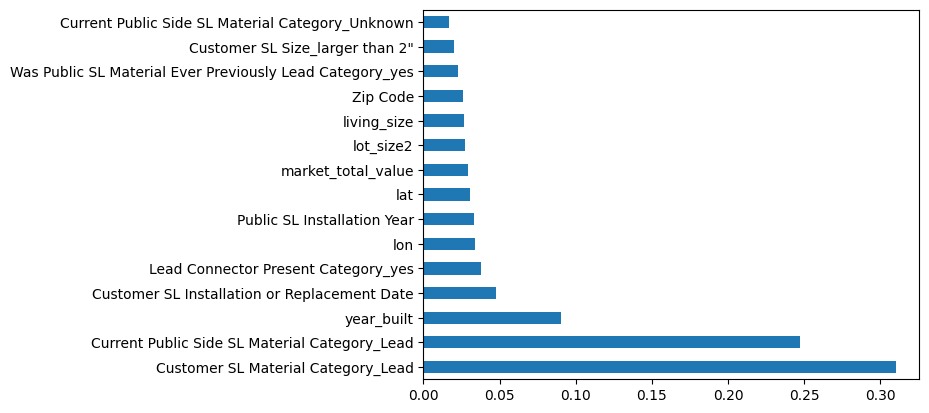

In [43]:
importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
top_15_importances = importances.nlargest(15)#.plot(kind='barh')

# 3. Normalize the Top 15 subset
normalized_top_15 = top_15_importances / top_15_importances.sum()

# 4. Plot the normalized subset
normalized_top_15.plot(kind='barh')

In [49]:
df.groupby('SL Category Cleaned')['Was Public SL Material Ever Previously Lead Category'].value_counts(normalize=True)

SL Category Cleaned  Was Public SL Material Ever Previously Lead Category
Lead                 no                                                      0.810466
                     yes                                                     0.185705
                     unknown                                                 0.003829
Non-Lead             no                                                      0.997381
                     yes                                                     0.002209
                     unknown                                                 0.000410
Unknown              no                                                      0.996961
                     unknown                                                 0.002256
                     yes                                                     0.000783
Name: proportion, dtype: float64

Upon further analysis, it looks like we have incredible predictions. This is most likely because some of our features are "leaking" the data. These are essentially proxies for our Target Variable so it could be incredibly biased

I went back and removed the top 2 most important features. However, now it performs poorly against lead but I guess that is to be expected when the majority of our data set is non-lead and unknown. Additionally, it seems like now the most important feature is latitude and longitude.